# 3D Reconstruction

**Please go through the notebook once before beginning working on it!**

In this notebook, we will extend our work from Task 1 to reconstruct a 3D model of a landmark using multiple images from the Heritage-Recon dataset.

#### Imports

In [380]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.optimize import least_squares


In [ ]:
# Helper functions.

def get_img_paths(folder_pth):
    """Returns a list containing filenames of all jpg files in folder_pth"""
    jpg_files = []

    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            # uncomment the line below if you want to include the entire path in the filename
            # filename = os.path.join(folder_pth, filename)
            jpg_files.append(filename)

    return jpg_files


def load_images(folder_pth):
    """Loads all images in folder_path"""
    images = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_pth, filename))
            images.append(img)

    return images


def resize_image(img, size=(800, 600)):
    """Resizes image to a specified size."""
    return cv2.resize(img, size)


def convert_to_grayscale(img):
    """Converts an image to grayscale."""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def load_selected_images(image_paths):
    """Loads only the images from the specified image paths."""
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        images.append(img)
    return images


def get_intrinsic_mat(image_name: str) -> list:
    with open("C:/Users/Lenovo/Desktop/Fall24/CS 436-CV-Murtaza Taj/project/bg_data/images.txt", "r") as image_file:
        if(image_file == None):
            print("NONE FOUND")
        image_lines = image_file.readlines()

    camera_id = None
    for i in range(0, len(image_lines), 2):
        line = image_lines[i].strip().split()
        if line[-1] == os.path.basename(image_name):
            camera_id = line[-2]

    with open("C:/Users/Lenovo/Desktop/Fall24/CS 436-CV-Murtaza Taj/project/bg_data/cameras.txt", "r") as cameras_file:
        if(cameras_file == None):
            print("NONE FOUND")
        camera_lines = cameras_file.readlines()

    if camera_id is not None:
        for line in camera_lines:
            parts = line.strip().split()
            if parts[0] == camera_id:
                return np.array([[float(parts[4]), 0, float(parts[6])],
                                 [0, float(parts[5]), float(parts[7])],
                                 [0,0,1]])

    return None

### Dataset Loading & Preprocessing
Similar to what we did in Task 1, but instead of only a few images, we will now load in and preprocess all the images in our dataset

In [382]:
import os
import numpy as np

def get_top_images_by_translation(images_file_path: str, top_n: int = 15) -> list:

    translations = []
    
    with open(images_file_path, "r") as image_file:
        image_lines = image_file.readlines()

    for i in range(0, len(image_lines), 2):
        line = image_lines[i].strip().split()
        
        # ensure the line has the correct format
        if len(line) < 10:
            print(f"Skipping malformed line {i}: {image_lines[i]}")
            continue
        
        try:
            # extract the necessary data
            image_name = line[-1]
            if (image_name == "34528631_8636161718.jpg") or (image_name == "62061899_598968557.jpg") or (image_name == "37623262_8687939901.jpg") or (image_name == "75037828_1434507967.jpg") or (image_name == "28328506_5139506977.jpg") or (image_name == "16117526_8247405609.jpg"):
                continue
            tx, ty, tz = map(float, line[5:8])
            
            # append the data as a tuple (image_name, TX, TY, TZ)
            translations.append((image_name, tx, ty, tz))
        except ValueError as e:
            print(f"Error processing line {i}: {image_lines[i]}")
            print(f"Error: {e}")
            continue
    
    # sort the translations based on the Euclidean norm of TX, TY, TZ
    sorted_translations = sorted(translations, key=lambda x: np.linalg.norm(x[1:]))
    
    top_images = [item[0] for item in sorted_translations[:top_n]]
    
    return top_images

images_file_path = "C:/Users/Lenovo/Desktop/Fall24/CS 436-CV-Murtaza Taj/project/bg_data/images.txt"
num = 10
desired_images = get_top_images_by_translation(images_file_path, top_n=num)
print(f"Top {num} Images:", desired_images)


Error processing line 0: # Image list with two lines of data per image:

Error: could not convert string to float: 'lines'
Skipping malformed line 2: #   POINTS2D[] as (X, Y, POINT3D_ID)

Top 10 Images: ['27175827_2221395482.jpg', '80142447_1434506947.jpg', '96812926_1435378218.jpg', '49514181_5267865935.jpg', '16090290_306696955.jpg', '62559633_3444342776.jpg', '45962310_5550442083.jpg', '63566481_6446510247.jpg', '71977687_5986915727.jpg', '80460739_5924637395.jpg']


In [383]:
base_directory = "D:/CV_Project/brandenburg_gate/dense/images"

IMAGES_PATH = [os.path.join(base_directory, img) for img in desired_images]

print("Images loaded in order:", IMAGES_PATH)

Images loaded in order: ['D:/CV_Project/brandenburg_gate/dense/images\\27175827_2221395482.jpg', 'D:/CV_Project/brandenburg_gate/dense/images\\80142447_1434506947.jpg', 'D:/CV_Project/brandenburg_gate/dense/images\\96812926_1435378218.jpg', 'D:/CV_Project/brandenburg_gate/dense/images\\49514181_5267865935.jpg', 'D:/CV_Project/brandenburg_gate/dense/images\\16090290_306696955.jpg', 'D:/CV_Project/brandenburg_gate/dense/images\\62559633_3444342776.jpg', 'D:/CV_Project/brandenburg_gate/dense/images\\45962310_5550442083.jpg', 'D:/CV_Project/brandenburg_gate/dense/images\\63566481_6446510247.jpg', 'D:/CV_Project/brandenburg_gate/dense/images\\71977687_5986915727.jpg', 'D:/CV_Project/brandenburg_gate/dense/images\\80460739_5924637395.jpg']


10


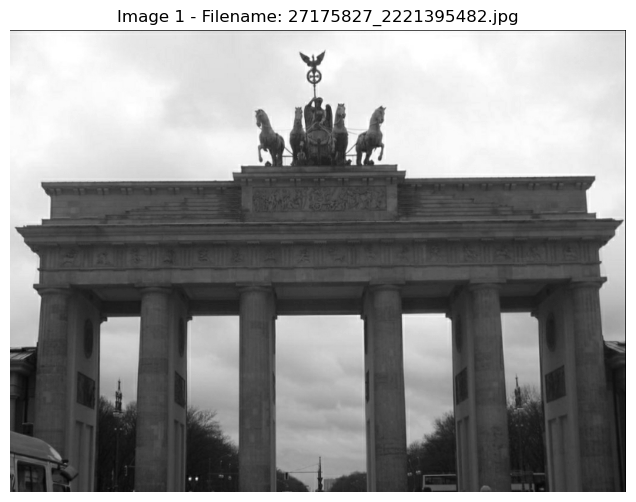

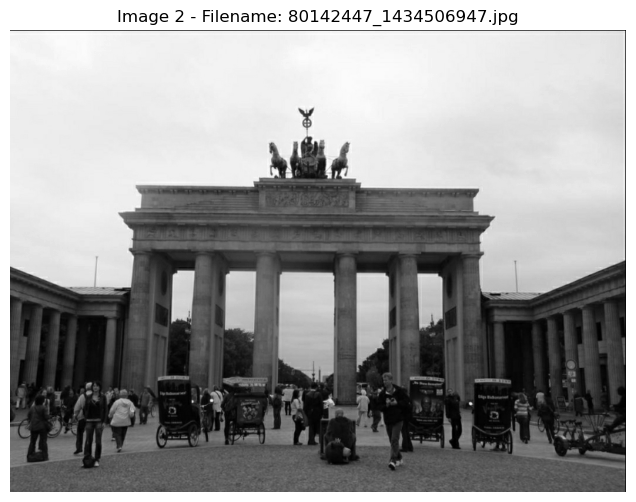

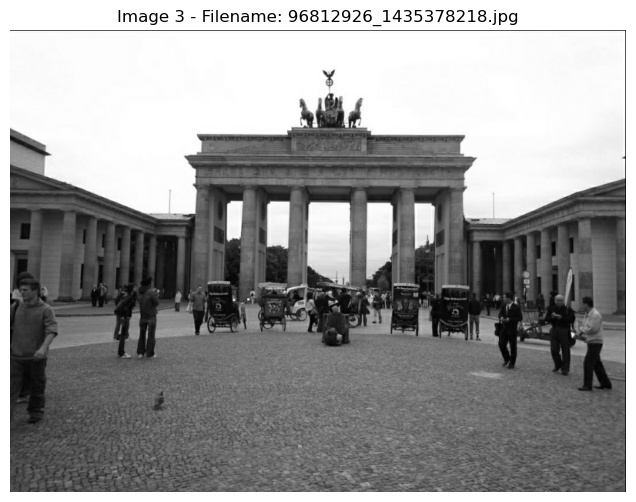

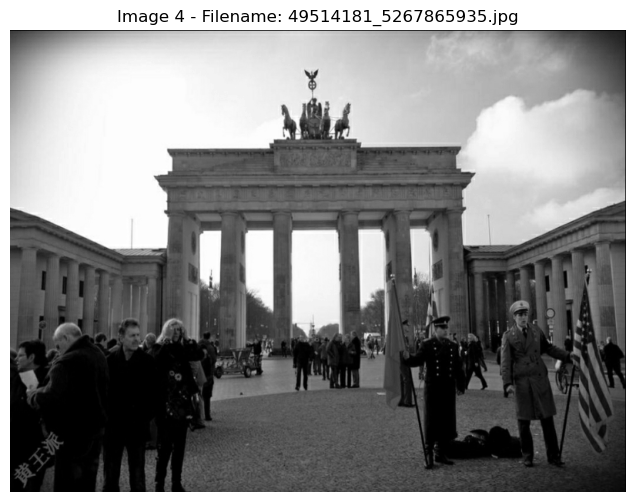

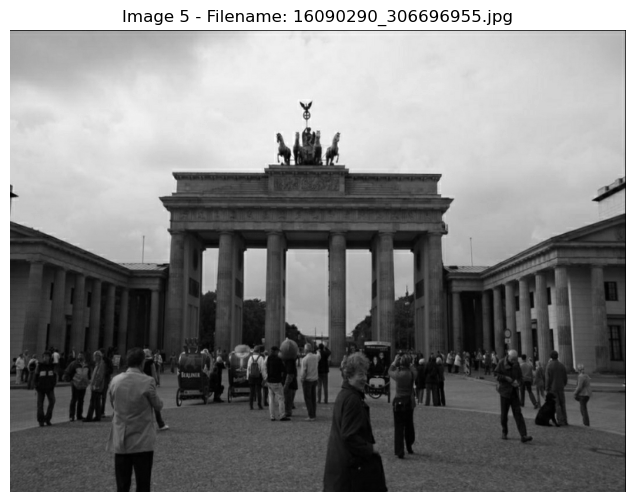

In [ ]:

images = load_selected_images(IMAGES_PATH)
print(len(images))

for idx in range(len(images)):
    images[idx] = convert_to_grayscale(resize_image(images[idx]))

for random_idx in range(min(len(images),5)):
    
    plt.figure(figsize=(10, 6))
    plt.imshow(images[random_idx], cmap='gray')
    plt.title(f'Image {random_idx+1} - Filename: {os.path.basename(IMAGES_PATH[random_idx])}')
    plt.axis('off')
    plt.show()

### Feature Detection & Matching (Across Multiple Images)
Extending what we did in Task 1, we will now extract the features from each image and match these features across all the images. However, this time you might want to consider extracting the best matches instead of all of them for each pair. Using the best matches improves the accuracy and reliability of our feature matching, which is crucial for the success of subsequent stages. Filtering out bad matches reduces the chance of errors propagating throughout the pipeline and results in a more robust and accurate 3D model.

Also display the results of feature detection and matching for any pair of images.

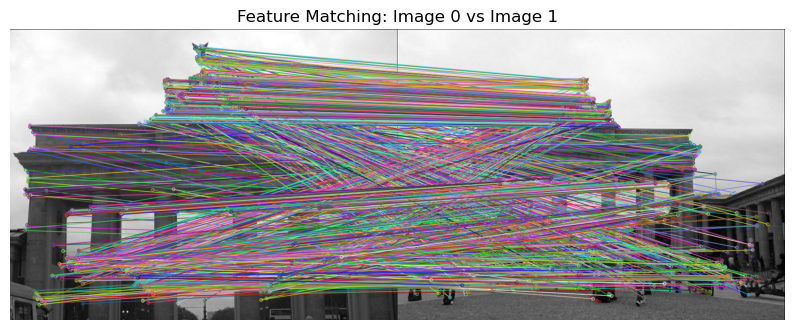

In [ ]:
orb_detector = cv2.ORB_create(nfeatures=6000, scoreType=cv2.ORB_FAST_SCORE)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

fd_mapping = dict()
matches_dict = dict()

TARGET_IMAGES = images
for idx, image in enumerate(TARGET_IMAGES):
    kpts, des = orb_detector.detectAndCompute(image, None)
    fd_mapping[idx] = (kpts, des, image)


for i in range(len(TARGET_IMAGES) - 1):
    good_matches = []
    matches = bf.knnMatch(fd_mapping[i][1], fd_mapping[i+1][1], k=2)
    for m, n in matches:
        if m.distance < 1* n.distance:
            good_matches.append(m)

    matches_dict[(i, i + 1)] = good_matches
    

def visualize_matches(idx1, idx2):
    kpts1, des1, img1 = fd_mapping[idx1]
    kpts2, des2, img2 = fd_mapping[idx2]
    good_matches = matches_dict[(idx1, idx2)]
    
    matched_image = cv2.drawMatches(
        img1, kpts1, img2, kpts2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(10, 10))
    plt.imshow(matched_image)
    plt.title(f"Feature Matching: Image {idx1} vs Image {idx2}")
    plt.axis("off")
    plt.show()

visualize_matches(0,1)

In [386]:
fd_mapping.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Camera Pose Estimation (Global)
We will estimate the relative camera poses (position and orientation) between consecutive image pairs. You can use the same technique as you did in Task 1 or switch to one of the others mentioned in the announcement on Slack.

In [ ]:
def estimate_camera_pose(feature_detection_results, matches_list, target_images_path):
    poses = {}

    for i in range(len(target_images_path) - 1):
        keypoints1, _, _ = feature_detection_results[i]
        keypoints2, _, _ = feature_detection_results[i+1]
        matches = matches_list[(i,i+1)]

        pts1 = np.array([keypoints1[m.queryIdx].pt for m in matches], dtype=np.float32)
        pts2 = np.array([keypoints2[m.trainIdx].pt for m in matches], dtype=np.float32)


        F, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)

        if F is None or F.size == 0:
            print("Fundamental matrix could not be computed.")

        pts1_inliers = pts1[mask.ravel() == 1]
        pts2_inliers = pts2[mask.ravel() == 1]

        K1 = get_intrinsic_mat(target_images_path[i])
        K2 = get_intrinsic_mat(target_images_path[i+1])


        E = K2.T @ F @ K1

        _, R, T, _ = cv2.recoverPose(E=E, points1=pts1_inliers, points2=pts2_inliers, cameraMatrix=K1)

        poses[(i,i+1)] = (R,T)

    return poses

In [388]:
target_images_path = IMAGES_PATH
poses = estimate_camera_pose(fd_mapping, matches_dict, target_images_path)

In [389]:
def compute_global_camera_poses(relative_poses):
    global_poses = {}
    R_global = np.eye(3)  
    T_global = np.zeros((3, 1)) 
    
    global_poses[0] = (R_global, T_global) 

    for (i, j), (R_rel, T_rel) in relative_poses.items():
        R_global = R_global @ R_rel
        T_global = T_global + R_global @ T_rel
        global_poses[j] = (R_global, T_global)

    return global_poses

In [390]:
global_poses = compute_global_camera_poses(poses)

### Choosing the technique
For this task, you have been given the choice of using either Structure from Motion (SfM) or Photogrammetry as your reconstruction method. A brief overview of the steps involved in each technique has been included in the handout provided to you. You can choose either technique for this task but before you choose one be sure to do a bit more research on each technique. I have also added some resources below to help you in understanding each technique.

[Understanding Structure From Motion Algorithms](https://medium.com/@loboateresa/understanding-structure-from-motion-algorithms-fc034875fd0c)\
[SfM](https://cmsc426.github.io/sfm/)\
[Chapter 13 - Structure from motion](https://mi.eng.cam.ac.uk/~cipolla/publications/contributionToEditedBook/2008-SFM-chapters.pdf)\
[What is Photogrammetry?](https://www.artec3d.com/learning-center/what-is-photogrammetry)\
[The Multi-View Environment](https://github.com/simonfuhrmann/mve)\
[open Multi-View Stereo](https://github.com/cdcseacave/openMVS)\
[Surface Reconstruction](https://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html)

**Technique chosen:** SFM

### 3D Reconstruction
Once you have chosen the technique, you can now start working on actually 3D reconstruction. Depending on the technique, follow the pipeline to generate the 3D point cloud for your landmark.

In [ ]:
def reconstruct_3d(fd_mapping, matches_dict, target_images_path, global_poses):
    reconstructed_points = []
    
    for i in range(len(target_images_path) - 2):  
        image_name1 = target_images_path[i]
        image_name2 = target_images_path[i+1]
        
        keypoints1, descriptors1, image1 = fd_mapping[i]
        keypoints2, descriptors2, image2 = fd_mapping[i+1]
        
        matches = matches_dict[(i,i+1)]
        
        pts1 = np.array([keypoints1[m.queryIdx].pt for m in matches], dtype=np.float32)
        pts2 = np.array([keypoints2[m.trainIdx].pt for m in matches], dtype=np.float32)
        
        
        K1 = get_intrinsic_mat(image_name1)
        K2 = get_intrinsic_mat(image_name2)
        R1, T1 = global_poses[i]     
        R2, T2 = global_poses[i+1]   
    
        P1 = K1 @ np.hstack((R1,T1))
        P2 = K2 @ np.hstack((R2,T2))

        points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
        points_3d = points_4d_hom[:3] / points_4d_hom[3]  
        points_3d = points_3d.T  

        # Cheirality check: Keep points with positive depths
        valid_points = points_3d[(points_4d_hom[3] > 0) & (points_3d[:, 2] > 0)]
        reconstructed_points.extend(valid_points)

    return np.array(reconstructed_points)

reconstructed_points = reconstruct_3d(fd_mapping, matches_dict, target_images_path, global_poses)

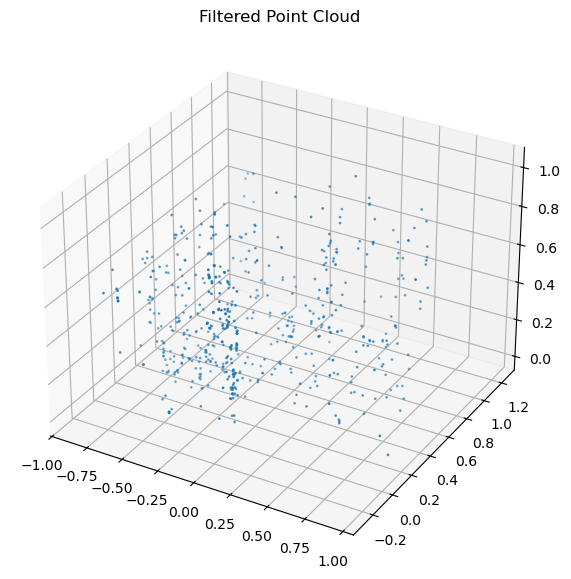

In [392]:
def filter_points_by_distance(points_3d, distance_threshold=50):
    distances = np.linalg.norm(points_3d, axis=1)  
    filtered_points = points_3d[distances < distance_threshold]
    return filtered_points

filtered_points = filter_points_by_distance(reconstructed_points, distance_threshold=50)

# Filtered point cloud.
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(filtered_points)

# Original final point cloud.
point_cloud_final = o3d.geometry.PointCloud()
point_cloud_final.points = o3d.utility.Vector3dVector(reconstructed_points)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(filtered_points[:, 0], filtered_points[:, 1], filtered_points[:, 2], s=1)
ax.set_title('Filtered Point Cloud')
plt.show()

### Mesh Generation & Texturing
Convert the 3D points generated into a 3D mesh and apply textures to it. You can use techniques like Poisson Surface Reconstruction for creating the mesh. For texturing, project the images onto the mesh based on the camera poses.

In [393]:
def point_cloud_to_mesh(points_3d):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=5)
    mesh = mesh.filter_smooth_simple(number_of_iterations=5)
    return mesh
# Didn't run.
mesh = point_cloud_to_mesh(filtered_points)
# o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)

### Visualization
Visualize the 3D model once you have generated it

In [ ]:
o3d.visualization.draw_geometries([point_cloud], window_name="3D Reconstruction")

### Save your model
Save the results from the 3D reconstruction process, which includes:

- The 3D point cloud data (sparse or dense depending on the method you used).
- The camera poses (rotation and translation matrices).
  
This step is essential for documenting and visualizing your results, and also for use in the final task. You can save the data in formats like .ply for point clouds or .obj for meshes, and save the matrices in standard formats like .npz (for NumPy arrays).qw

In [395]:
o3d.io.write_point_cloud("filtered_point_cloud_NEW.ply", point_cloud)
o3d.io.write_point_cloud("final_point_cloud_NEW.ply", point_cloud_final)
poses_output = {
    str(k): {"R": v[0], "T": v[1]} for k, v in poses.items()
}
np.savez("relative_camera_poses_NEW.npz",**poses_output)

### Conversion to .obj format

---

In [396]:
import trimesh

ply_file = "C:/Users/Lenovo/Desktop/Fall24/CS 436-CV-Murtaza Taj/project/deliv2/submission/filtered_point_cloud_NEW.ply"
mesh = trimesh.load(ply_file)

glb_file = "bg_model.glb"
mesh.export(glb_file)
print(f"Converted {ply_file} to {glb_file}")

Converted C:/Users/Lenovo/Desktop/Fall24/CS 436-CV-Murtaza Taj/project/deliv2/submission/filtered_point_cloud_NEW.ply to bg_model.glb


For .obj file rendering

In [ ]:
ply_file = "C:/Users/Lenovo/Desktop/Fall24/CS 436-CV-Murtaza Taj/project/deliv2/submission/filtered_point_cloud_NEW.ply"
mesh = trimesh.load(ply_file)

obj_file = "rendered_model.obj"
mesh.export(obj_file)

print(f"Converted {ply_file} to {obj_file}")

Converted C:/Users/Lenovo/Desktop/Fall24/CS 436-CV-Murtaza Taj/project/deliv2/submission/filtered_point_cloud_NEW.ply to rendered_model.obj
